In [1]:
import os
# Ignore TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.datasets import imdb

from deepthink.layers import Embedding, GlobalAveragePooling1D, Dense
from deepthink.model import Model
from deepthink.optimizers import Adam
from deepthink.loss import BinaryCrossEntropy
from deepthink.activations import Sigmoid
from deepthink.utils import pad_sequences

# Set default matplotlib style
plt.style.use('ggplot')

## IMDB Sentiment Analysis

The purpose of this notebook is to demonstrate text-classification using [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). This example is inspired by [this](https://www.tensorflow.org/tutorials/keras/text_classification) TensorFlow tutorial.

#### IMDB Dataset

The dataset used is the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movie reviews from [imdb.com](https://www.imdb.com/) split into 25,000 for training and 25,000 for testing. Each review is classed as positive or negative (1 or 0 respectively) and the goal is to predict this from the review text. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

In [2]:
# Define the parameters
max_features = 10000  # Maximum vocab size
seq_len = 200  # Maximum length of each review
embedding_dim = 16
batch_size = 32
epochs = 10
learning_rate = 0.001

In [3]:
# Load the data
(train_text, train_labels), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Reshape labels to column vector
train_labels = train_labels.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(train_text.shape, train_labels.shape)
print(X_test.shape, y_test.shape)

(25000,) (25000, 1)
(25000,) (25000, 1)


In [4]:
# View a sample review
sample = np.random.choice(train_text)
# Get the word index for each word in the review
word_to_idx = imdb.get_word_index()
# Create a reverse word index
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert the review to text
review = ' '.join([idx_to_word.get(idx - 3, '?') for idx in sample])
print(review)

? dark rising is your typical bad obviously quickly produced horror sci fi fantasy movie it has a strange unexplained plot with holes so big you could fit an elephant through them most of the time i didn't know what the hell was going on but it didn't really matter it was a simple demon hunter returns from hell dimension to save ? story with confusing stuff added on about witches and a book of evil with plot elements and characters who make no sense or disappear totally for no reason the acting is bad but there honestly is not much they can do with this script i am guessing there is a couple topless scenes which is probably the only reason this bad movie got made like so many other bad movies give this one a pass unless there is nothing else on t v


In [5]:
# Pad the sequences
train_text = pad_sequences(train_text, seq_len)
X_test = pad_sequences(X_test, seq_len)

In [6]:
# Shuffle the data and split into training and validation sets
# (20k training, 5k validation as per the TensorFlow tutorial)
train_size = 20000
random_perm = np.random.permutation(train_text.shape[0])
train_text = train_text[random_perm]
train_labels = train_labels[random_perm]

X_train = train_text[:train_size]
y_train = train_labels[:train_size]
X_valid = train_text[train_size:]
y_valid = train_labels[train_size:]

In [7]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (20000, 200)
y_train: (20000, 1)
X_valid: (5000, 200)
y_valid: (5000, 1)


In [8]:
# Define the model
opt = Adam(learning_rate=learning_rate)
model = Model(opt, cost=BinaryCrossEntropy(),
              batch_size=batch_size,
              metrics=['accuracy'])

model.add_layer(Embedding(max_features, embedding_dim,
                          input_shape=(batch_size, seq_len)))
model.add_layer(GlobalAveragePooling1D())
model.add_layer(Dense(1))
model.add_layer(Sigmoid())

model.initialize()

In [9]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Embedding Layer           (None, 16, 200)                  160000
GlobalAveragePooling1D    (None, 16)                            0
Dense(1)                  (None, 1)                            17
Sigmoid Activation        (None, 1)                             0
Total params: 160017


In [10]:
history = model.train((X_train, y_train),
                      validation_data=(X_valid, y_valid),
                      epochs=epochs)

100%|██████████| 625/625 [00:07<00:00, 82.86it/s]


Epoch: 1/10, elapsed-time: 7.75s - loss: 0.5806 - accuracy: 0.7927 - val_loss: 0.5832 - val_accuracy: 0.7855 - 


100%|██████████| 625/625 [00:07<00:00, 80.35it/s]


Epoch: 2/10, elapsed-time: 15.58s - loss: 0.5128 - accuracy: 0.8157 - val_loss: 0.4577 - val_accuracy: 0.8313 - 


100%|██████████| 625/625 [00:07<00:00, 83.37it/s]


Epoch: 3/10, elapsed-time: 23.13s - loss: 0.4078 - accuracy: 0.8545 - val_loss: 0.3912 - val_accuracy: 0.8476 - 


100%|██████████| 625/625 [00:07<00:00, 81.06it/s]


Epoch: 4/10, elapsed-time: 30.89s - loss: 0.3473 - accuracy: 0.8733 - val_loss: 0.3545 - val_accuracy: 0.8580 - 


100%|██████████| 625/625 [00:07<00:00, 81.33it/s]


Epoch: 5/10, elapsed-time: 38.63s - loss: 0.3090 - accuracy: 0.8851 - val_loss: 0.3327 - val_accuracy: 0.8640 - 


100%|██████████| 625/625 [00:07<00:00, 82.91it/s]


Epoch: 6/10, elapsed-time: 46.22s - loss: 0.2810 - accuracy: 0.8961 - val_loss: 0.3204 - val_accuracy: 0.8678 - 


100%|██████████| 625/625 [00:07<00:00, 84.41it/s]


Epoch: 7/10, elapsed-time: 53.67s - loss: 0.2589 - accuracy: 0.9034 - val_loss: 0.3115 - val_accuracy: 0.8738 - 


100%|██████████| 625/625 [00:07<00:00, 81.66it/s]


Epoch: 8/10, elapsed-time: 61.37s - loss: 0.2403 - accuracy: 0.9116 - val_loss: 0.3052 - val_accuracy: 0.8754 - 


100%|██████████| 625/625 [00:07<00:00, 79.88it/s]


Epoch: 9/10, elapsed-time: 69.25s - loss: 0.2244 - accuracy: 0.9183 - val_loss: 0.3049 - val_accuracy: 0.8748 - 


100%|██████████| 625/625 [00:07<00:00, 81.86it/s]

Epoch: 10/10, elapsed-time: 76.94s - loss: 0.2101 - accuracy: 0.9242 - val_loss: 0.3001 - val_accuracy: 0.8772 - 


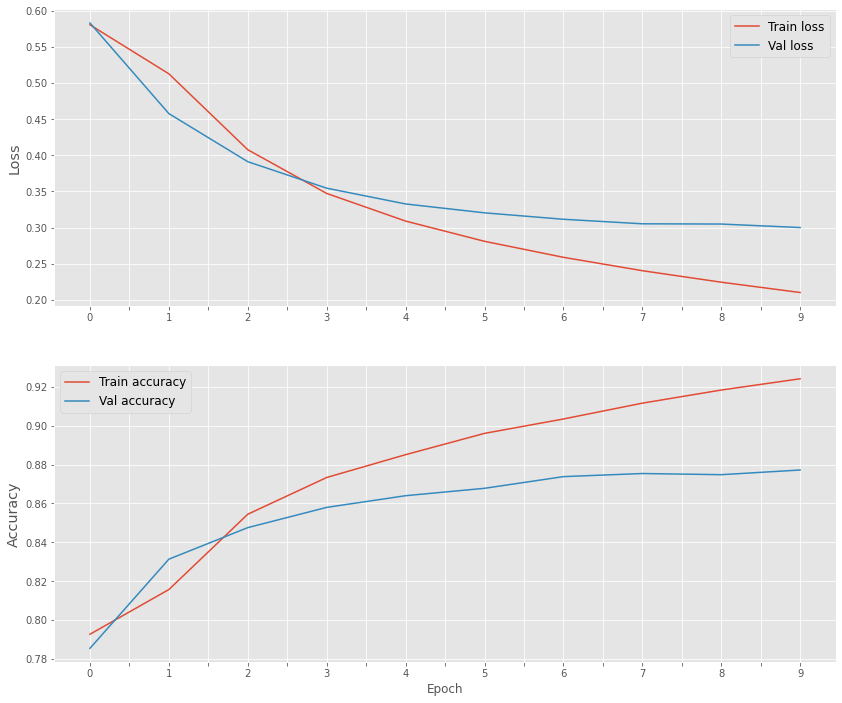

In [11]:
# Plot training history

history.plot_history()

In [12]:
# Evaluate on test data
test_preds = model.get_predictions(X_test)
test_labels = y_test[:test_preds.shape[0]]
test_loss = BinaryCrossEntropy()(test_labels, test_preds)
binary_preds = np.round(test_preds)
test_acc = np.mean(binary_preds == test_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2%}')


Test Loss: 0.3264
Test Accuracy: 86.18%
